# Null Model and Distributional Model
The target variable is price. We'll create a null model and distributional model for this.




In [1]:
%matplotlib inline

In [11]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb
from pandas.api.types import is_numeric_dtype
from tabulate import tabulate

sns.set(style="whitegrid")

THEME = "darkslategray"


In [3]:
print(duckdb.__version__)

0.5.1


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Connect/create duckDB file

In [5]:
con = duckdb.connect(database='PS6.duckdb', read_only=True)


# Get the Data

In [8]:
all_listings = con.execute('''select * from latest_listings;''').df()
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10560 entries, 0 to 10559
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10560 non-null  int64         
 1   listing_url                                   10560 non-null  object        
 2   scrape_id                                     10560 non-null  int64         
 3   last_scraped                                  10560 non-null  datetime64[ns]
 4   name                                          10559 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10560 non-null  object        
 8   host_id                                       10560 non-null  int3

# Price Data Filtering

In EDA, we discovered a few filters that could be used to remove erroneous data (e.g. free rooms that accomodate 0 people):

* Price is 0
* Accommodates is 0

In [9]:
price_positive = all_listings.price > 0
accomodates_positive = all_listings.accommodates > 0

listings = all_listings[price_positive & accomodates_positive]
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10554 entries, 0 to 10559
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            10554 non-null  int64         
 1   listing_url                                   10554 non-null  object        
 2   scrape_id                                     10554 non-null  int64         
 3   last_scraped                                  10554 non-null  datetime64[ns]
 4   name                                          10553 non-null  object        
 5   description                                   10416 non-null  object        
 6   neighborhood_overview                         6559 non-null   object        
 7   picture_url                                   10554 non-null  object        
 8   host_id                                       10554 non-null  int3

We'll work from this data set.

# Distribution

In [19]:
listings.price.describe()

count    10554.000000
mean       198.294486
std        422.557271
min         10.000000
25%         85.000000
50%        129.000000
75%        206.000000
max      24999.000000
Name: price, dtype: float64

The prices are concentrated on the left side of the distribution, with the 25th percentile at 85 and the median at $129 ($44 difference). Compare this to the right side of the distribution going from the median at $129 to the 75th percentile at $206 ($77 difference).  

On top of this, the minimum is at $10, $119 away from the median, but the maximum is at $24,999, which dwarfs the median.



In [21]:
upper_quartile_prices = listings[listings.price > 206]
upper_quartile_prices.price.describe()

count     2632.000000
mean       461.794073
std        785.586077
min        207.000000
25%        246.000000
50%        300.000000
75%        437.000000
max      24999.000000
Name: price, dtype: float64

Looking at just the upper quartile of prices, 75% of these are below $437.

In [13]:
## Code taken from Lab 5 solution
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  11


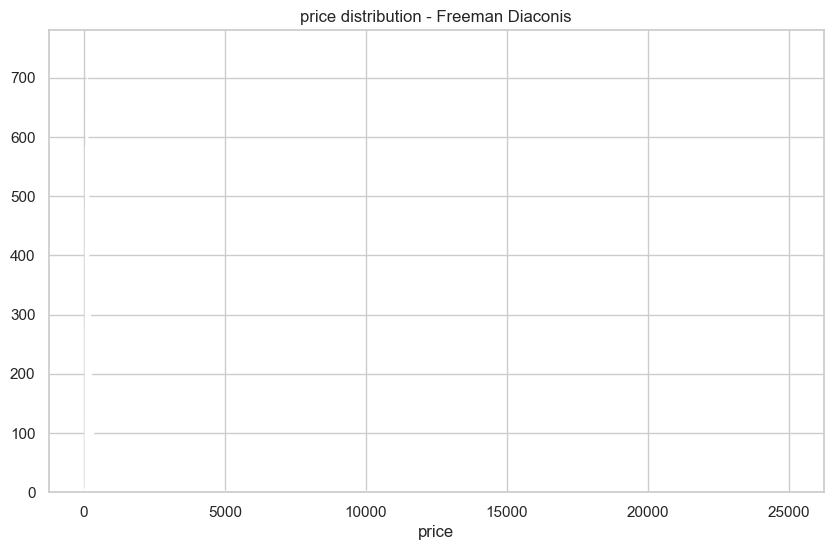

In [14]:
h = freeman_diaconis(listings.price)
plot_data = listings.price
variable_name = "price"
print("Freeman Diaconis: ", h)
mn = int(plot_data.min())
mx = int(plot_data.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data,bins=bins, color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

Using freeman-diaconis to bin the prices, the resulting plot is not readable. We know that the maximum at $24,999 and the other extreme high priced-values will require some work to plot.  

This time, we'll manually set the bins.

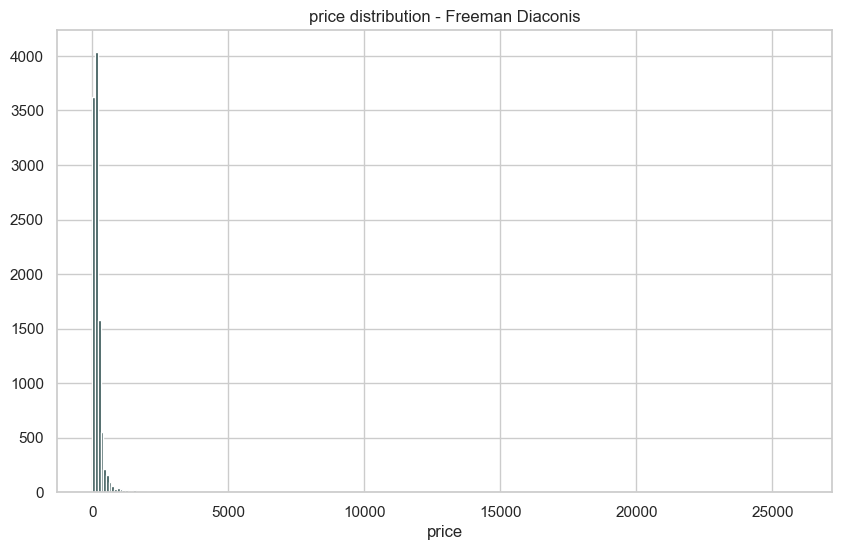

In [16]:
#h = freeman_diaconis(listings.price)
plot_data = listings.price
variable_name = "price"
#print("Freeman Diaconis: ", h)
#mn = int(plot_data.min())
#mx = int(plot_data.max())
#bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, bins=range(0,26000,100),color="darkslategray")
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

This is still difficult to read.  

We'll need to restrict the plotting window further.

In [26]:
pct_data_plotted = listings[listings.price < 500].shape[0] / listings.shape[0]
pct_data_plotted

0.9482660602615123

95% of the price data is below $500. We'll use that for our x limit in the plot below.

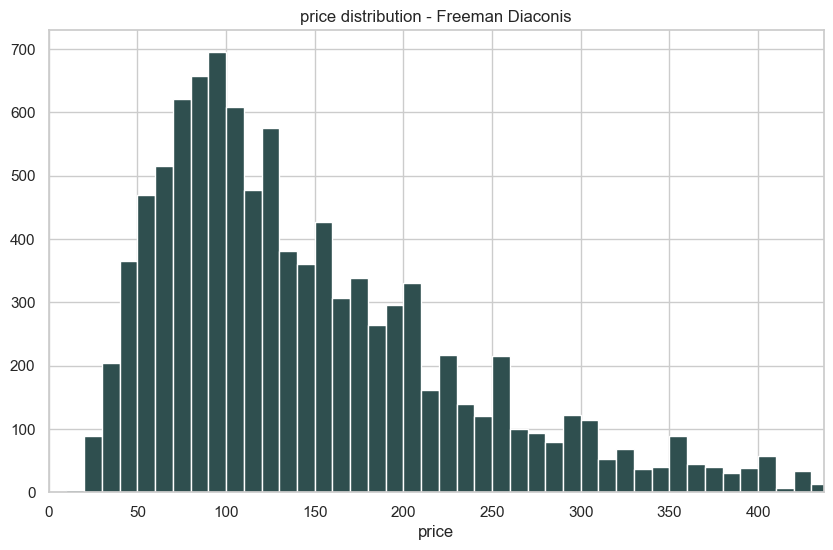

In [23]:
#h = freeman_diaconis(listings.price)
plot_data = listings.price
variable_name = "price"
#print("Freeman Diaconis: ", h)
#mn = int(plot_data.min())
#mx = int(plot_data.max())
#bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(plot_data, bins=range(0,500,10),color="darkslategray")
axes.set(xlim=[0,437])
axes.set_title(variable_name + " distribution - Freeman Diaconis")
axes.set_xlabel(variable_name)

plt.show()
plt.close()

The resulting plot shows a right-skewed distribution.

In [ ]:
con.execute("select property_type, room_type, accommodates, bathrooms, bathrooms_text, bedrooms, beds, amenities, price from latest_listings;")
listings = con.fetchall()

# Mean Model (or Null Model)

## Initial Model

We'd like to predict the price for an AirBNB listing in the Washington, D.C. area. Using the mean, overestimates and underestimates will be penalized the same.

In [10]:
price_predict = np.mean(listings.price)
price_predict

198.29448550312677

Picking a random AirBNB listing in the Washington, D.C. area, knowing nothing else about the listing, we predict that the price will be $198.



In [28]:
price_error = np.std(listings.price) * 1.96
price_error

828.1730137913075

This doesn't look good because the lower bounds will be negative. I don't think anyone will pay us to stay in an AirBNB.

In [29]:
[price_predict - price_error, price_predict + price_error]

[-629.8785282881807, 1026.4674992944342]

The 95% error abounds are from -$630 to $1026. 